In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [07:19:06] Enabling RDKit 2019.09.3 jupyter extensions
[07:19:06] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

number of all smiles:  2050
not successfully processed smiles:  O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
not successfully processed smiles:  c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
not successfully processed smiles:  Cc1nc(sc1)\[NH]=C(\N)N
not successfully processed smiles:  s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N


not successfully processed smiles:  c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1ccccc1
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
not successfully processed smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
not successfully processed smiles:  s1cc(nc1\[NH]=C(\N)N)C
not successfully processed smiles:  c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC


number of successfully processed smiles:  2039


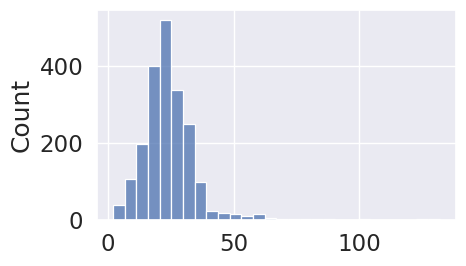

In [4]:
task_name = 'BBBP'
tasks = ['BBBP']
raw_filename = "../data/BBBP.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 188
random_seed = int(time.time())
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,BBBP,smiles,cano_smiles


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_prc, test_precision, test_recall, test_loss


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_prc, train_precision, train_recall, train_loss = eval(model, train_df)
    valid_roc, valid_prc, valid_precision, valid_recall, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.87:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.35964880424681966]
valid_roc:[0.3549725442342892]



EPOCH:	1
train_roc:[0.7683272272838939]
valid_roc:[0.794020744356315]



EPOCH:	2
train_roc:[0.7823793298655245]
valid_roc:[0.813300793166565]



EPOCH:	3
train_roc:[0.7933531290388045]
valid_roc:[0.8330689444783405]



EPOCH:	4
train_roc:[0.798873140147186]
valid_roc:[0.8444173276388042]



EPOCH:	5
train_roc:[0.8086015188575457]
valid_roc:[0.8461256863941429]



EPOCH:	6
train_roc:[0.8145466391805433]
valid_roc:[0.8490543014032947]



EPOCH:	7
train_roc:[0.8189429947769244]
valid_roc:[0.8605247101891397]



EPOCH:	8
train_roc:[0.824768486376211]
valid_roc:[0.8658938377059182]



EPOCH:	9
train_roc:[0.8299894256753148]
valid_roc:[0.8704087858450275]



EPOCH:	10
train_roc:[0.8341251615521827]
valid_roc:[0.8772422208663819]



EPOCH:	11
train_roc:[0.8375516699956206]
valid_roc:[0.8768761439902379]



EPOCH:	12
train_roc:[0.8342917872744945]
valid_roc:[0.8677242220866382]



EPOCH:	13
train_roc:[0.8361673947641071]
valid_roc:[0.8834655277608298]



EPOCH:	14
train_roc:[0.8362870234878182]
valid_roc:[0.8782184258694327]



EPOCH:	15
train_roc:[0.8438108157183598]
valid_roc:[0.8827333740085418]



EPOCH:	16
train_roc:[0.8487519092530682]
valid_roc:[0.888712629652227]



EPOCH:	17
train_roc:[0.8538254488747422]
valid_roc:[0.889078706528371]



EPOCH:	18
train_roc:[0.8572498210909711]
valid_roc:[0.8915192190359976]



EPOCH:	19
train_roc:[0.861180479155763]
valid_roc:[0.8932275777913362]



EPOCH:	20
train_roc:[0.864149834976448]
valid_roc:[0.8951799877974375]



EPOCH:	21
train_roc:[0.8661813870523268]
valid_roc:[0.8937156802928615]



EPOCH:	22
train_roc:[0.8684180169402818]
valid_roc:[0.8977425259304455]



EPOCH:	23
train_roc:[0.8642481014280678]
valid_roc:[0.8900549115314217]



EPOCH:	24
train_roc:[0.8678519167298635]
valid_roc:[0.8955460646735814]



EPOCH:	25
train_roc:[0.8668585710776199]
valid_roc:[0.8946918852959121]



EPOCH:	26
train_roc:[0.8696762547664569]
valid_roc:[0.8985967053081146]



EPOCH:	27
train_roc:[0.8735342811061384]
valid_roc:[0.90091519219036]



EPOCH:	28
train_roc:[0.8760080322143062]
valid_roc:[0.90091519219036]



EPOCH:	29
train_roc:[0.8787872638133792]
valid_roc:[0.9037217815741306]



EPOCH:	30
train_roc:[0.8802868953141857]
valid_roc:[0.9056741915802319]



EPOCH:	31
train_roc:[0.8807953173899576]
valid_roc:[0.9011592434411226]



EPOCH:	32
train_roc:[0.8826452901530606]
valid_roc:[0.9035997559487492]



EPOCH:	33
train_roc:[0.883177210728133]
valid_roc:[0.903111653447224]



EPOCH:	34
train_roc:[0.8834079232667186]
valid_roc:[0.8993288590604027]



EPOCH:	35
train_roc:[0.8866913044871453]
valid_roc:[0.9060402684563759]



EPOCH:	36
train_roc:[0.8865225425376243]
valid_roc:[0.8977425259304455]



EPOCH:	37
train_roc:[0.8874261666470846]
valid_roc:[0.9054301403294691]



EPOCH:	38
train_roc:[0.8895730749922561]
valid_roc:[0.9032336790726053]



EPOCH:	39
train_roc:[0.8904019311493969]
valid_roc:[0.9054301403294692]



EPOCH:	40
train_roc:[0.8917520267455648]
valid_roc:[0.9032336790726052]



EPOCH:	41
train_roc:[0.8929034532112835]
valid_roc:[0.9057962172056131]



EPOCH:	42
train_roc:[0.8899063264368798]
valid_roc:[0.9037217815741306]



EPOCH:	43
train_roc:[0.8915918097048803]
valid_roc:[0.9021354484441733]



EPOCH:	44
train_roc:[0.8925937002659603]
valid_roc:[0.8992068334350213]



EPOCH:	45
train_roc:[0.893640451598432]
valid_roc:[0.8988407565588774]



EPOCH:	46
train_roc:[0.8954455635901435]
valid_roc:[0.9028676021964612]



EPOCH:	47
train_roc:[0.8966824391442274]
valid_roc:[0.9057962172056132]



EPOCH:	48
train_roc:[0.8983316065496726]
valid_roc:[0.9010372178157413]



EPOCH:	49
train_roc:[0.8990835585272849]
valid_roc:[0.9067724222086638]



EPOCH:	50
train_roc:[0.9009719833801524]
valid_roc:[0.8982306284319707]



EPOCH:	51
train_roc:[0.898389284684319]
valid_roc:[0.9004270896888347]



EPOCH:	52
train_roc:[0.8999209595932623]
valid_roc:[0.9071384990848078]



EPOCH:	53
train_roc:[0.9020935026649435]
valid_roc:[0.9040878584502746]



EPOCH:	54
train_roc:[0.9044134454140542]
valid_roc:[0.9046979865771811]



EPOCH:	55
train_roc:[0.9046890187240315]
valid_roc:[0.8977425259304455]



EPOCH:	56
train_roc:[0.9071948132403362]
valid_roc:[0.9045759609517998]



EPOCH:	57
train_roc:[0.9071798596498724]
valid_roc:[0.900183038438072]



EPOCH:	58
train_roc:[0.9050949018937655]
valid_roc:[0.9011592434411226]



EPOCH:	59
train_roc:[0.9087499866485799]
valid_roc:[0.9079926784624771]



EPOCH:	60
train_roc:[0.906259145722739]
valid_roc:[0.9037217815741305]



EPOCH:	61
train_roc:[0.9104012902812343]
valid_roc:[0.9033557046979865]



EPOCH:	62
train_roc:[0.9096023413050212]
valid_roc:[0.9089688834655277]



EPOCH:	63
train_roc:[0.9140232635143074]
valid_roc:[0.9035997559487493]



EPOCH:	64
train_roc:[0.9153509287247792]
valid_roc:[0.9055521659548506]



EPOCH:	65
train_roc:[0.9180810270980422]
valid_roc:[0.8987187309334961]



EPOCH:	66
train_roc:[0.9152206188650225]
valid_roc:[0.8996949359365467]



EPOCH:	67
train_roc:[0.9170748640825438]
valid_roc:[0.9077486272117146]



EPOCH:	68
train_roc:[0.9198220522734798]
valid_roc:[0.9025015253203172]



EPOCH:	69
train_roc:[0.9205697317966739]
valid_roc:[0.8945698596705308]



EPOCH:	70
train_roc:[0.9230755263129786]
valid_roc:[0.9090909090909091]



EPOCH:	71
train_roc:[0.9157183598047487]
valid_roc:[0.9070164734594265]



EPOCH:	72
train_roc:[0.9264806724843254]
valid_roc:[0.9040878584502746]



EPOCH:	73
train_roc:[0.9272112621898464]
valid_roc:[0.9099450884685784]



EPOCH:	74
train_roc:[0.9289736496373755]
valid_roc:[0.9083587553386211]



EPOCH:	75
train_roc:[0.9284502739711396]
valid_roc:[0.9075045759609519]



EPOCH:	76
train_roc:[0.9301955716009955]
valid_roc:[0.8971323978035387]



EPOCH:	77
train_roc:[0.9313469980667144]
valid_roc:[0.9122635753508237]



EPOCH:	78
train_roc:[0.9290548262713222]
valid_roc:[0.9045759609517999]



EPOCH:	79
train_roc:[0.9314794441536802]
valid_roc:[0.9186089078706529]



EPOCH:	80
train_roc:[0.9341774991188062]
valid_roc:[0.9089688834655277]



EPOCH:	81
train_roc:[0.9262798671266677]
valid_roc:[0.9133618059792556]



EPOCH:	82
train_roc:[0.9264080407592151]
valid_roc:[0.923489932885906]



EPOCH:	83
train_roc:[0.9302959742798245]
valid_roc:[0.8939597315436242]



EPOCH:	84
train_roc:[0.929172318767824]
valid_roc:[0.9039658328248932]



EPOCH:	85
train_roc:[0.9326778676179999]
valid_roc:[0.9187309334960342]



EPOCH:	86
train_roc:[0.936935368445788]
valid_roc:[0.9143380109823063]



EPOCH:	87
train_roc:[0.9358266665242515]
valid_roc:[0.9150701647345942]



EPOCH:	88
train_roc:[0.9390865492453777]
valid_roc:[0.912385600976205]



EPOCH:	89
train_roc:[0.9395287482776667]
valid_roc:[0.9189749847467968]



EPOCH:	90
train_roc:[0.9382641017698642]
valid_roc:[0.9193410616229408]



EPOCH:	91
train_roc:[0.940293517618534]
valid_roc:[0.9121415497254424]



EPOCH:	92
train_roc:[0.9421862149258196]
valid_roc:[0.9062843197071385]



EPOCH:	93
train_roc:[0.9408681627377888]
valid_roc:[0.903111653447224]



EPOCH:	94
train_roc:[0.9391634534249063]
valid_roc:[0.9203172666259914]



EPOCH:	95
train_roc:[0.9357583072535595]
valid_roc:[0.9208053691275168]



EPOCH:	96
train_roc:[0.9411992779552034]
valid_roc:[0.9206833435021354]



EPOCH:	97
train_roc:[0.9406545400168761]
valid_roc:[0.9114093959731544]



EPOCH:	98
train_roc:[0.944858635164436]
valid_roc:[0.9159243441122635]



EPOCH:	99
train_roc:[0.9419640472960703]
valid_roc:[0.8999389871873094]



EPOCH:	100
train_roc:[0.9453029704239342]
valid_roc:[0.9054301403294692]



EPOCH:	101
train_roc:[0.9459438385866721]
valid_roc:[0.9023794996949359]



EPOCH:	102
train_roc:[0.9463390406203604]
valid_roc:[0.9187309334960342]



EPOCH:	103
train_roc:[0.9457622592738963]
valid_roc:[0.9095790115924344]



EPOCH:	104
train_roc:[0.9470674940986722]
valid_roc:[0.9057962172056132]



EPOCH:	105
train_roc:[0.9490029159501405]
valid_roc:[0.9129957291031117]



EPOCH:	106
train_roc:[0.9487529773666727]
valid_roc:[0.9066503965832825]



EPOCH:	107
train_roc:[0.9498723604242547]
valid_roc:[0.9171446003660768]



EPOCH:	108
train_roc:[0.9453051066511434]
valid_roc:[0.8922513727882856]



EPOCH:	109
train_roc:[0.9465313010691817]
valid_roc:[0.9042098840756558]



EPOCH:	110
train_roc:[0.9476528203539727]
valid_roc:[0.9128737034777303]



EPOCH:	111
train_roc:[0.9505815878576845]
valid_roc:[0.9150701647345942]



EPOCH:	112
train_roc:[0.9520406310415175]
valid_roc:[0.9112873703477731]



EPOCH:	113
train_roc:[0.9502248379137604]
valid_roc:[0.9184868822452715]



EPOCH:	114
train_roc:[0.9407143543787317]
valid_roc:[0.9129957291031117]



EPOCH:	115
train_roc:[0.9421285367911731]
valid_roc:[0.9164124466137888]



EPOCH:	116
train_roc:[0.9516176580541107]
valid_roc:[0.9115314215985357]



EPOCH:	117
train_roc:[0.9519338196810613]
valid_roc:[0.9055521659548506]



EPOCH:	118
train_roc:[0.9534099526825672]
valid_roc:[0.9103111653447223]



In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features,num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_prc, test_precision, test_recall, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:82
test_roc:[0.8754006410256412]
test_roc_mean: 0.8754006410256412
